# Python的内存管理机制
**如果想要用C，C++扩展Python本身（基于CPython），可以参考中文文档https://docs.python.org/zh-cn/3.6/c-api/memory.html**

网络上已经有很多文章简要地说明了Cpython的内存管理机制，这篇文章会比大部分的回答详细一些。
你将能够了解到的东西包括：
* python内关于内存的底层计算
* 理解Python是如何抽象底层的抽象
* Python的内存管理算法

---
## 内存是一本空白的书

可以这么想象计算机的内存——一本用来记录各种小故事的空白书本。当然迟早会有不同的作者来书写他们的“小故事”。作者们在创作时不能互相协作，另一方面，如果想要开始进行创作，必须得向内存管理器这位管理者提出申请，然后管理器会告诉他们在哪写。

同时，当书本中的故事不再有人读或者不会再被人引用时，他们将会为了空出纸张（空间）而被清除。可能你会问为什么要用书作为内存的类比，很重要的一点是，内容被记载在书上，一般都是会占用**接连的纸张**。而内存管理也一样，对象时常会占用连续的内存。

那么，刚刚提到的“作者”是谁想必聪明的各位已经知道了——没错，就是OS内不同的进程。

## 内存管理：从硬到软

数据被记入内存的过程叫做**内存分配**，这个过程是由内存管理器来完成的。
回到我们的主题，Python以及软硬件之间的关系，显然在Python程序与计算机进行交互的过程中，硬件（内存管理的话，就是RAM）显而易见地位于底层，而他和Python程序之间有着非常多层的抽象，其中就包括了操作系统（operating system）。

## 官方Python实现

一般来说，我们说的“Python”一般指Cpython实现的语言，而这个实现（包括解释和编译）又是由C语言实现的的。内存管理算法已经Python内置数据结构的实现都能在Cpython中找到，因此咱们研究的重点在Cpython上，C不是面对对象的，因此对Python的实现中充满了tricks。

像我们耳熟能详的“Python中的一切都是对象”，说的具体一点，就是在Cpython的实现中，有一个叫"PyObject"的结构体，Python中的所有对象都是它的实现。

PyObject的实现中，只有两样东西：
* ob_refcnt：引用计数
* ob_type:指向其他类型的指针

引用计数是一个整数，用来做垃圾回收（garbage collection）。而ob_type是指向其他Python具体实现的一个指针，这其中，每一个具体实现都有自身特定的内存分配器以及释放器用以获取内存存储对象以及释放内存。

然而，让我们来想一下一种坏情况，由于内存是计算机的共享资源，试想如果有两个进程对同一个地址进行写操作。这一定是会发生问题的。

## GIL
The Global Interpreter Lock。字入其名是一把锁，它是对刚刚提到共享内存问题的一个解决方案。回到最开始的类比中去，两个作者相对同一页进行操作，那么能想到的最终结果就是，内容彼此覆盖，造成不可读的结果。所以，解决方案也比较粗暴，那就是设把锁，当一个进程对共享内存进行操作时，其他进程就被锁挡在外面而不能做任何操作了。

Cpython的GIL执行操作时，整个解释器都被锁住了，这保证了安全性。
想要对GIL有更细致的了解，可参考https://realpython.com/python-gil/。

## GC
刚刚已经提过le ,不再被引用的数据会被清除调，这里说的具体指的就是引用计数掉到0的数据。
首先，python中对对象进行引用（包括被作为参数调用），或者被填充到某个容器中都会使对象的引用计数增加。sys.getrefcount()可以查看一个对象的引用计数，当这个数字降到0的时候，内部存储（PyObjects）会"frees"掉已经被分配的空间，这样其他对象就可以使用那块内存了。那么，"frees"到底做了什么？

## CPython的内存管理
讲内存管理了~系好安全带！
首先，OS特定的虚拟内存管理器会为Python解释器进程分配一块内存。那么这块内存长什么样呢？
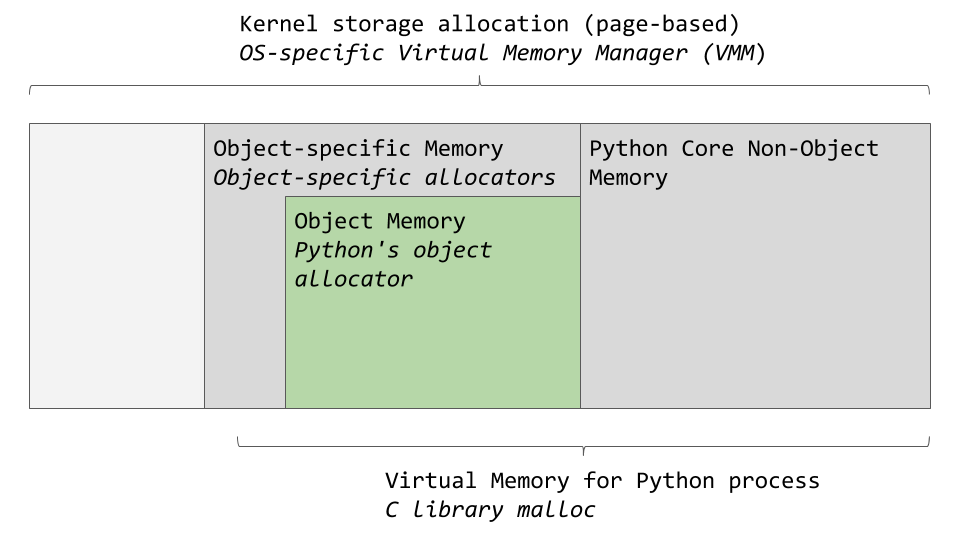
喏，长这样。
首先，会有一块区域用于存储非对象内存的。另一部分则是被分配存储对象的（你所知道的**int,dict什么的**），当然了，这张图被简化了，如果你想了解得更细致，来，https://github.com/python/cpython/blob/7d6ddb96b34b94c1cbdf95baa94492c48426404e/Objects/obmalloc.c ，这是源码。

CPython有一个对象分配器专门负责为对象专用区域分配内存，每当有新的对象需要被分配空间或者删除的时候，都需要用到这个分配器。当增添或者移除一个list或者int这样的对象时不会涉及到太多的数据，因此分配器在对少量数据处理时会做尽量少的改动，甚至不进行内存的分配。

首先要提到,这部分的代码使用了C的一个库——**malloc**，专做内存分配。让我们来更细致地看看CPython的内存分配策略，看图：

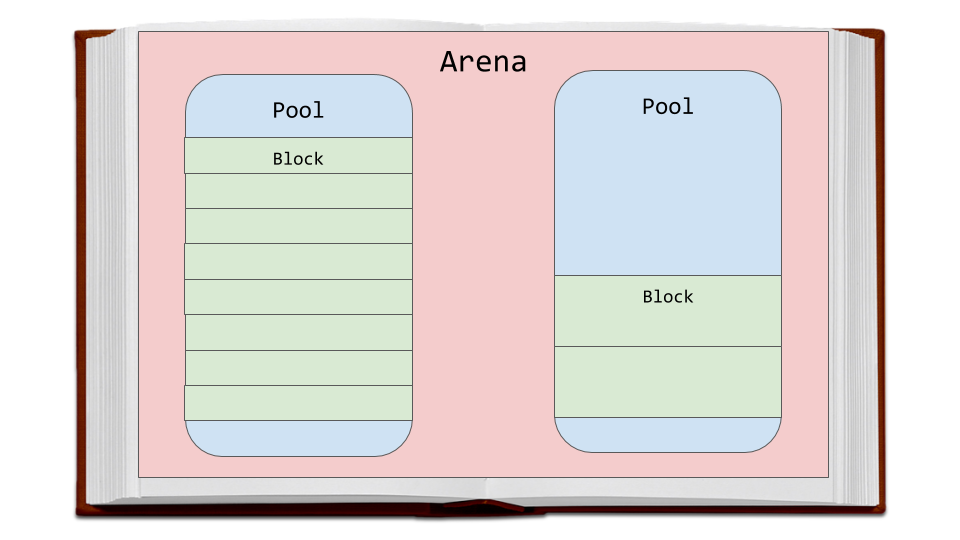
图中的Areanas是最大的块，其边界互相之间能对其（又回到了最开始的那个类比）。图中的每一页的边界，是OS会使用的定长连续内存块，Python中假设系统的page size是256kb。
Arenas里面的是pools,代表着虚拟内存页(4Kb),而Pool又被切分为更小的内存块，每一个块在被请求某个范围内的bytes时，会申请该范围内定长的bytes：

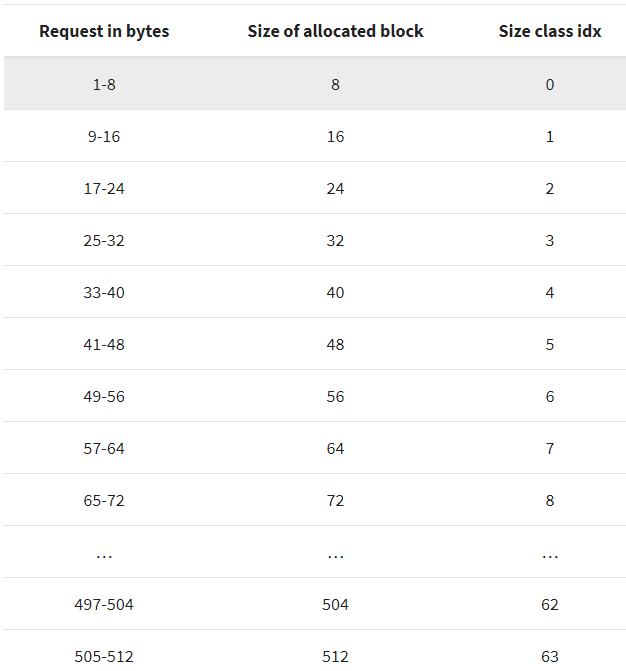

### Pools
如图所示，一个Pools由固定size class的多个块组成。由size class能将Pool分成不同类，同一类的Pool之间以双向链表地形式相连，这确保了在块大小给定的情况下，算法能够找到合适的空间进行分配。

对于不同尺寸的pools，解释器会用usedpools追踪那些已经为数据分配内存的pools（放入其中）。因此Pools对象本身一定会是：被使用，被填满，空。这三种状态中的其中一种。其中空状态的pool可以储存任意的class size。

freepools追踪所有空状态的pools。当需要8bytes空间的内存，又没有符合规格的pools时，就从freepools中取出~

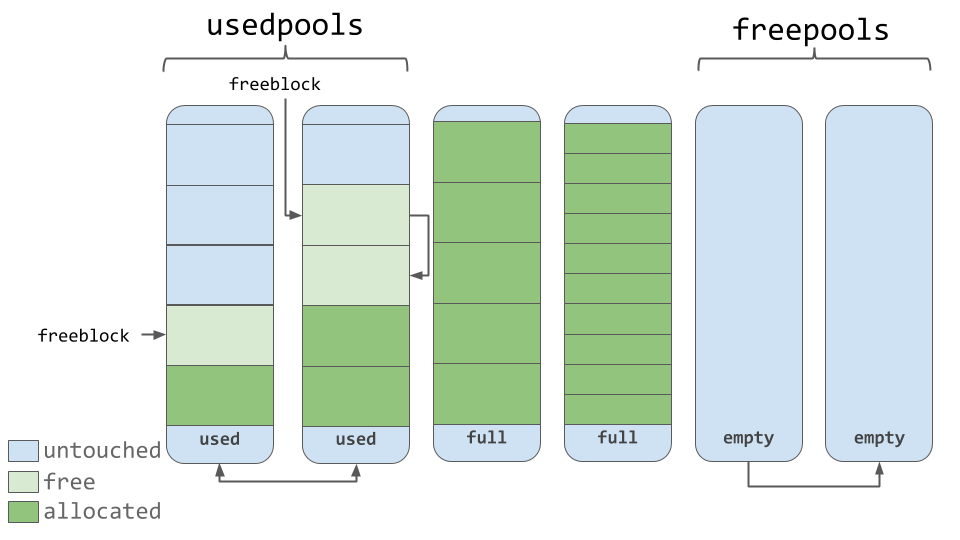
值得注意的是，pools里面的数据块一共有3种状态：
* untouched:没有被分配过内存的块
* free:曾被分配过，但后来释放了的块。
* allocated:含有相关数据的内存

其中，freeblock的指针指向一个由空块内存组成的单链表。如果需要更多可用free的数据块，内存管理器会在pool中使用untouched的块。

## Arenas
Arenas包含pools，但他们本身不想pools那样有明确的状态。取而代之的是，Arenas被一个成为usable_arenas的双向链表装载，这个表有一个规则，所含free pools的数量越少，Arenas则越靠近表的前端。这意味着，装载数据越多的arena越有可能被选为存放新数据的候选。

为什么要这么做呢？实际上，"free"并不代表内存已经被确切地释放还给操作系统，CPython会保持块的被分配状态，并在之后为新数据而使用它。

即，真正能够被释放，返还给操作系统的，只有Arenas，那些接近于空的arenas的内存将会被还给操作系统，减少Python程序的空间占用。